Step: 1
Date: 2022-10-05 00:00:00
Balance: $10000.00
Net Worth: $10000.00
Profit: $0.00
Position: None
Step: 2
Date: 2022-10-05 00:00:00
Balance: $10000.00
Net Worth: $10000.00
Profit: $0.00
Position: None
Step: 3
Date: 2022-10-05 00:00:00
Balance: $10000.00
Net Worth: $10000.00
Profit: $0.00
Position: None
Step: 4
Date: 2022-10-05 00:00:00
Balance: $10000.00
Net Worth: $10000.00
Profit: $0.00
Position: None
Step: 5
Date: 2022-10-05 00:00:00
Balance: $10000.00
Net Worth: $10000.00
Profit: $0.00
Position: None
Step: 6
Date: 2022-10-05 00:00:00
Balance: $10000.00
Net Worth: $10000.00
Profit: $0.00
Position: None
Step: 7
Date: 2022-10-05 00:00:00
Balance: $10000.00
Net Worth: $10000.00
Profit: $0.00
Position: None
Step: 8
Date: 2022-10-05 00:00:00
Balance: $10000.00
Net Worth: $10000.00
Profit: $0.00
Position: None
Step: 9
Date: 2022-10-05 00:00:00
Balance: $10000.00
Net Worth: $10000.00
Profit: $0.00
Position: None
Step: 10
Date: 2022-10-05 00:00:00
Balance: $10000.00
Net Worth: $10000.0

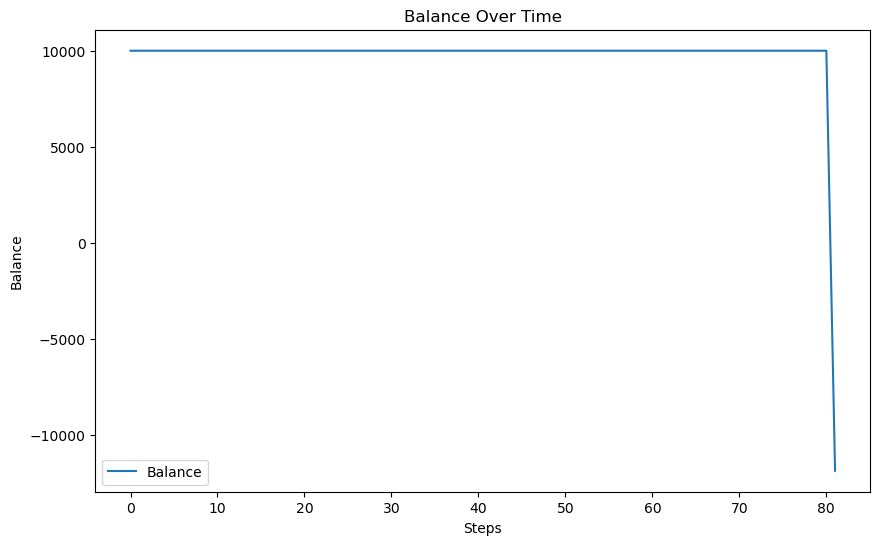

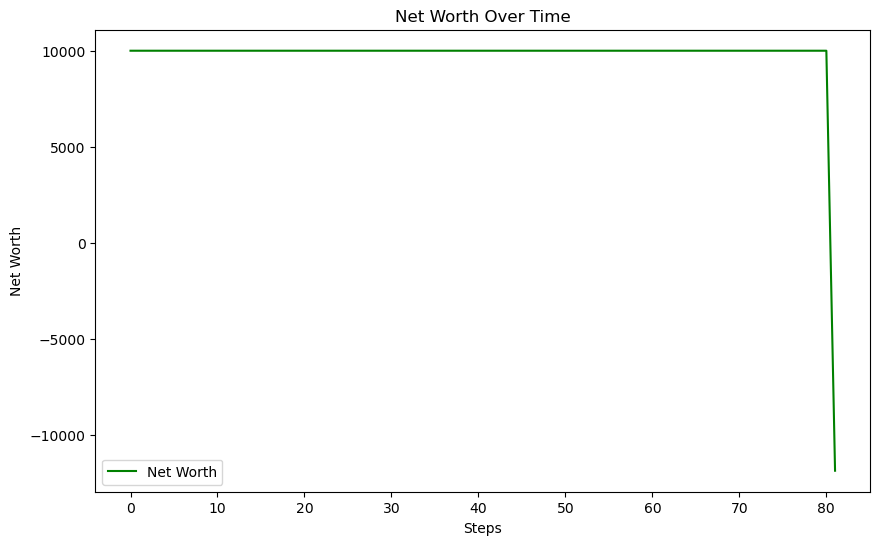

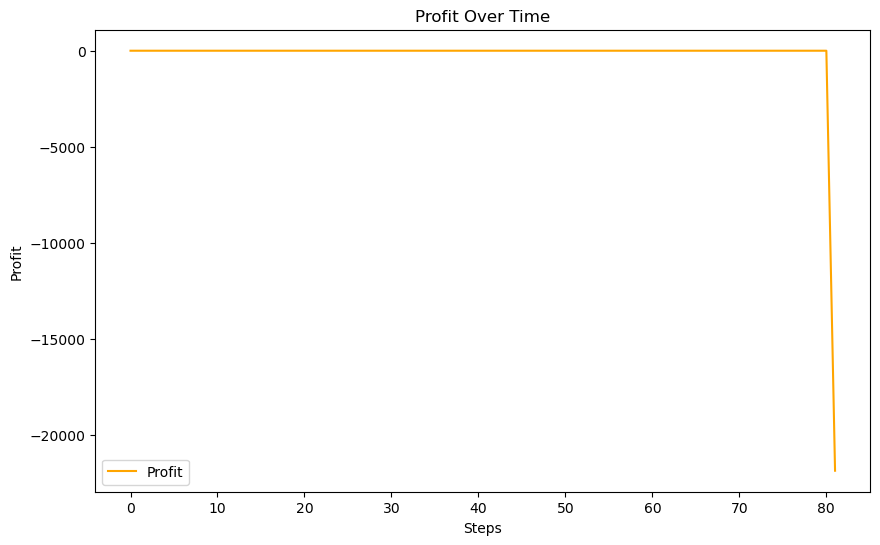

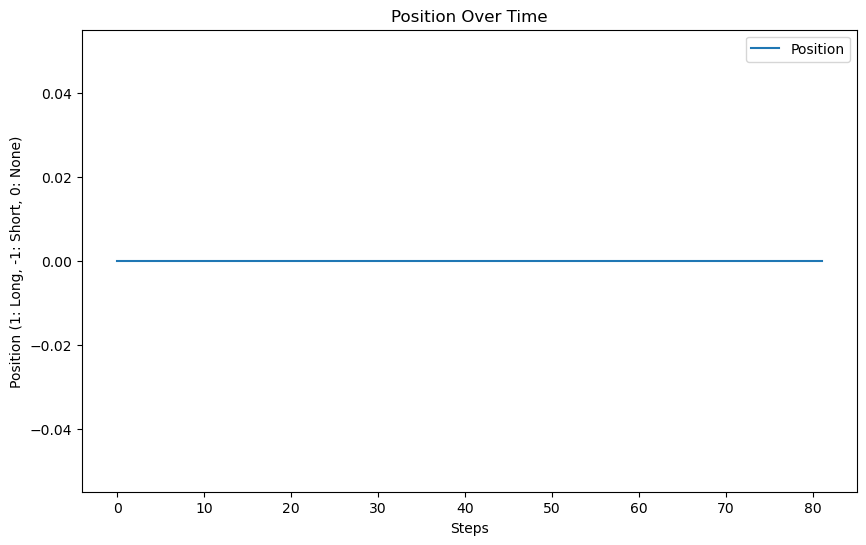

In [27]:
# ================================
# 1. IMPORTING LIBRARIES
# ================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import ta
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from collections import Counter

# =================================
# 2. LOADING AND PREPROCESSING DATA
# =================================
# Load data
df = pd.read_csv(r'C:\Users\Daniel\Documents\Trading\Trading Bot\EURUSD-H1-2Years.csv', delimiter='\t')
df.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVol', 'Vol', 'Spread']

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ensure 'Time' is in datetime.time format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Combine 'Date' and 'Time' into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# Feature Engineering: Extracting Hour and Minute, Cyclical Encoding
df['Hour'] = df['Time'].apply(lambda x: x.hour)
df['Minute'] = df['Time'].apply(lambda x: x.minute)

# Cyclical encoding for Hour (0-23)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Cyclical encoding for Minute (0-59)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)

# Dropping unnecessary columns
df.drop(['Hour', 'Minute', 'Vol', 'Time', 'Minute_sin', 'Minute_cos'], axis=1, inplace=True)

# ================================
# 3. ADDING TECHNICAL INDICATORS
# ================================
# 1. Simple Moving Averages (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(close=df['Close'], window=10).sma_indicator()
df['SMA_50'] = ta.trend.SMAIndicator(close=df['Close'], window=50).sma_indicator()

# 2. Exponential Moving Averages (EMA)
df['EMA_12'] = ta.trend.EMAIndicator(close=df['Close'], window=12).ema_indicator()
df['EMA_26'] = ta.trend.EMAIndicator(close=df['Close'], window=26).ema_indicator()

# 3. Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()

# 4. MACD (Moving Average Convergence Divergence)
macd = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Diff'] = macd.macd_diff()

# 5. Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
df['Bollinger_High'] = bollinger.bollinger_hband()
df['Bollinger_Low'] = bollinger.bollinger_lband()
df['Bollinger_Middle'] = bollinger.bollinger_mavg()

# 6. Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()

# 7. On-Balance Volume (OBV)
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['TickVol']).on_balance_volume()

# 8. Ichimoku Cloud
ichimoku = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], window1=9, window2=26, window3=52)
df['Ichimoku_A'] = ichimoku.ichimoku_a()
df['Ichimoku_B'] = ichimoku.ichimoku_b()

# 9. Commodity Channel Index (CCI)
df['CCI'] = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=20).cci()

# 10. Volume-Weighted Average Price (VWAP)
df['VWAP'] = ta.volume.VolumeWeightedAveragePrice(high=df['High'], low=df['Low'], close=df['Close'], volume=df['TickVol']).volume_weighted_average_price()

# ================================
# 4. HANDLING MISSING VALUES
# ================================
# Forward fill to handle NaNs
df = df.ffill()
# Drop remaining NaN rows
df = df.dropna().reset_index(drop=True)

# =====================================
# 5. COMBINING ALL FEATURES AND SCALING
# =====================================
# Combine all features (price, volume, and technical indicators) for scaling
features_to_scale = ['Open', 'High', 'Low', 'Close', 'TickVol', 'Spread']
features_to_scale_ti = [
    'SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff',
    'Bollinger_High', 'Bollinger_Low', 'Bollinger_Middle', 'ATR',
    'OBV', 'Ichimoku_A', 'Ichimoku_B', 'CCI', 'VWAP'
]
all_features_to_scale = features_to_scale + features_to_scale_ti

# Scale all combined features at once
scaler = MinMaxScaler()
df[all_features_to_scale] = scaler.fit_transform(df[all_features_to_scale])

# Save the scaler for future use (e.g., during inference or further training)
joblib.dump(scaler, 'scaler.pkl')

# =======================================================================
# 6. DEFINING FOREX TRADING RL ENVIRONMENT WITH MINIMUM ONE TRADE PER DAY
# =======================================================================
class ForexTradingEnv(gym.Env):
    """Custom Environment for Forex Trading (EUR/USD H1) with Minimum One Trade Per Day"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(ForexTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_step = 0

        # Define action and observation space
        self.action_space = spaces.Discrete(3)  # 0: Hold/Close, 1: Buy, 2: Sell

        # Observation space shape should match the number of features in each observation
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(23,), dtype=np.float32
        )

        # Initialize trading parameters
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.position = 0  # 0: No position, 1: Long, -1: Short
        self.entry_price = 0
        self.last_price = self.df.iloc[self.current_step]['Close']

        # Data collection for plotting
        self.balance_history = []
        self.net_worth_history = []
        self.profit_history = []
        self.position_history = []

        # Risk management parameters
        self.risk_per_trade = 0.01      # 1% of capital
        self.stop_loss_pct = 0.01       # 1% stop loss
        self.max_drawdown_pct = 0.08    # 8% maximum drawdown

        # Leverage
        self.leverage = 100              # 1:100 leverage

        # Initialize position size
        self.position_size = 0           # In units

        # Pip value for EUR/USD
        self.pip_value = 10              # $10 per pip for 1 standard lot (100,000 units)

        # Maximum lot size to prevent unrealistic positions
        self.max_lots = 10               # Example: Maximum 10 standard lots

        # Initialize trade logs
        self.trades = []  # List to store trade information

        # Initialize variables for enforcing minimum one trade per day
        self.current_date = self.df.iloc[self.current_step]['Date']
        self.trades_today = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Handle seeding if necessary
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.position = 0
        self.entry_price = 0
        self.current_step = 0
        self.last_price = self.df.iloc[self.current_step]['Close']
        self.position_size = 0
        self.trades = []  # Reset trade logs
        self.balance_history = []
        self.net_worth_history = []
        self.profit_history = []
        self.position_history = []
        # Reset date and trades per day
        self.current_date = self.df.iloc[self.current_step]['Date']
        self.trades_today = 0
        observation = self._next_observation()
        info = {}
        return observation, info

    def _next_observation(self):
        obs = self.df.iloc[self.current_step][[
            'Open', 'High', 'Low', 'Close', 'TickVol', 'Spread',
            'Hour_sin', 'Hour_cos', 'SMA_10', 'SMA_50', 'RSI',
            'MACD', 'MACD_Signal', 'MACD_Diff', 'Bollinger_High',
            'Bollinger_Low', 'Bollinger_Middle', 'ATR', 'OBV',
            'Ichimoku_A', 'Ichimoku_B', 'CCI', 'VWAP'
        ]].values
        return obs.astype(np.float32)

    def step(self, action):
        done = False
        reward = 0
        info = {}

        # Get current date and check if day has changed
        prev_date = self.current_date
        self.current_date = self.df.iloc[self.current_step]['Date']
        if self.current_date != prev_date:
            # Day has changed, check if at least one trade was made
            if self.trades_today == 0:
                # Penalize the agent for not making a trade
                reward -= 1  # Adjust the penalty as needed
            # Reset trades_today counter
            self.trades_today = 0

        current_price = self.df.iloc[self.current_step]['Close']
        spread = self.df.iloc[self.current_step]['Spread']

        # Adjust prices for spread
        if self.position == 1:
            current_price_adj = current_price - (spread / 2)
        elif self.position == -1:
            current_price_adj = current_price + (spread / 2)
        else:
            current_price_adj = current_price

        # Execute action
        if action == 1:  # Buy
            if self.position == 0:
                # Open new long position
                self.position = 1
                self.entry_price = current_price + (spread / 2)
                self.last_price = self.entry_price

                # Risk management
                self.stop_loss_price = self.entry_price * (1 - self.stop_loss_pct)
                stop_loss_distance = self.entry_price - self.stop_loss_price

                # Calculate position size in units with leverage and cap at max_lots
                risk_amount = self.balance * self.risk_per_trade
                calculated_position_size = (risk_amount * self.leverage) / stop_loss_distance
                self.position_size = min(calculated_position_size, self.max_lots * 100000)

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Buy',
                    'price': self.entry_price,
                    'position_size': self.position_size
                })

                # Increment trades_today counter
                self.trades_today += 1

            elif self.position == -1:
                # Close short position and open long position
                profit_loss = (self.entry_price - current_price_adj) * self.position_size
                self.balance += profit_loss
                self.net_worth = self.balance
                reward += profit_loss

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Close Short',
                    'price': current_price_adj,
                    'profit_loss': profit_loss
                })

                # Open new long position
                self.position = 1
                self.entry_price = current_price + (spread / 2)
                self.last_price = self.entry_price

                # Risk management for new position
                self.stop_loss_price = self.entry_price * (1 - self.stop_loss_pct)
                stop_loss_distance = self.entry_price - self.stop_loss_price

                # Calculate position size in units with leverage and cap at max_lots
                risk_amount = self.balance * self.risk_per_trade
                calculated_position_size = (risk_amount * self.leverage) / stop_loss_distance
                self.position_size = min(calculated_position_size, self.max_lots * 100000)

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Buy',
                    'price': self.entry_price,
                    'position_size': self.position_size
                })

                # Increment trades_today counter
                self.trades_today += 1

        elif action == 2:  # Sell
            if self.position == 0:
                # Open new short position
                self.position = -1
                self.entry_price = current_price - (spread / 2)
                self.last_price = self.entry_price

                # Risk management
                self.stop_loss_price = self.entry_price * (1 + self.stop_loss_pct)
                stop_loss_distance = self.stop_loss_price - self.entry_price

                # Calculate position size in units with leverage and cap at max_lots
                risk_amount = self.balance * self.risk_per_trade
                calculated_position_size = (risk_amount * self.leverage) / stop_loss_distance
                self.position_size = min(calculated_position_size, self.max_lots * 100000)

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Sell',
                    'price': self.entry_price,
                    'position_size': self.position_size
                })

                # Increment trades_today counter
                self.trades_today += 1

            elif self.position == 1:
                # Close long position and open short position
                profit_loss = (current_price_adj - self.entry_price) * self.position_size
                self.balance += profit_loss
                self.net_worth = self.balance
                reward += profit_loss

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Close Long',
                    'price': current_price_adj,
                    'profit_loss': profit_loss
                })

                # Open new short position
                self.position = -1
                self.entry_price = current_price - (spread / 2)
                self.last_price = self.entry_price

                # Risk management for new position
                self.stop_loss_price = self.entry_price * (1 + self.stop_loss_pct)
                stop_loss_distance = self.stop_loss_price - self.entry_price

                # Calculate position size in units with leverage and cap at max_lots
                risk_amount = self.balance * self.risk_per_trade
                calculated_position_size = (risk_amount * self.leverage) / stop_loss_distance
                self.position_size = min(calculated_position_size, self.max_lots * 100000)

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Sell',
                    'price': self.entry_price,
                    'position_size': self.position_size
                })

                # Increment trades_today counter
                self.trades_today += 1

        elif action == 0:  # Hold or close position
            if self.position != 0:
                # Close existing position
                if self.position == 1:
                    profit_loss = (current_price_adj - self.entry_price) * self.position_size
                    action_type = 'Close Long'
                elif self.position == -1:
                    profit_loss = (self.entry_price - current_price_adj) * self.position_size
                    action_type = 'Close Short'

                self.balance += profit_loss
                self.net_worth = self.balance
                reward += profit_loss

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': action_type,
                    'price': current_price_adj,
                    'profit_loss': profit_loss
                })

                # Reset position
                self.position = 0
                self.entry_price = 0
                self.position_size = 0

                # Increment trades_today counter
                self.trades_today += 1

        # Penalize the 'Hold' action to encourage trading
        if action == 0:
            reward -= 0.01  # Adjust the penalty as needed

        # Check for stop loss
        if self.position == 1 and (current_price_adj <= self.stop_loss_price):
            # Close long position
            profit_loss = (current_price_adj - self.entry_price) * self.position_size
            self.balance += profit_loss
            self.net_worth = self.balance
            reward += profit_loss

            # Log the trade
            self.trades.append({
                'step': self.current_step,
                'action': 'Stop Loss Close Long',
                'price': current_price_adj,
                'profit_loss': profit_loss
            })

            # Reset position
            self.position = 0
            self.entry_price = 0
            self.position_size = 0

            # Increment trades_today counter
            self.trades_today += 1

        elif self.position == -1 and (current_price_adj >= self.stop_loss_price):
            # Close short position
            profit_loss = (self.entry_price - current_price_adj) * self.position_size
            self.balance += profit_loss
            self.net_worth = self.balance
            reward += profit_loss

            # Log the trade
            self.trades.append({
                'step': self.current_step,
                'action': 'Stop Loss Close Short',
                'price': current_price_adj,
                'profit_loss': profit_loss
            })

            # Reset position
            self.position = 0
            self.entry_price = 0
            self.position_size = 0

            # Increment trades_today counter
            self.trades_today += 1

        # Calculate reward for holding position
        if self.position != 0:
            # Calculate the profit/loss since the last step
            price_change = current_price_adj - self.last_price
            reward += price_change * self.position * self.position_size

            # Update net worth based on current position
            self.net_worth = self.balance + ((current_price_adj - self.entry_price) * self.position * self.position_size)
        else:
            price_change = 0

        # Update last price
        self.last_price = current_price_adj

        # Update max net worth and check for drawdown
        self.max_net_worth = max(self.max_net_worth, self.net_worth)
        drawdown = (self.max_net_worth - self.net_worth) / self.max_net_worth
        if drawdown >= self.max_drawdown_pct:
            done = True
            reward -= 10  # Penalize for exceeding max drawdown

        # Move to next step
        self.current_step += 1

        # Check if done (end of data)
        if self.current_step >= len(self.df) - 1:
            done = True

        # Append data for plotting
        profit = self.net_worth - self.initial_balance
        self.balance_history.append(self.balance)
        self.net_worth_history.append(self.net_worth)
        self.profit_history.append(profit)
        self.position_history.append(self.position)

        # Scale the reward
        scaled_reward = reward / 1000  # Adjust the divisor based on your data
        
        # Truncated flag
        truncated = False

        return self._next_observation(), scaled_reward, done, truncated, info

    def render(self, mode='human', close=False):
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Date: {self.df.iloc[self.current_step]["Date"]}')
        print(f'Balance: ${self.balance:.2f}')
        print(f'Net Worth: ${self.net_worth:.2f}')
        print(f'Profit: ${profit:.2f}')
        print(f'Position: {"Long" if self.position == 1 else "Short" if self.position == -1 else "None"}')

# =================================
# 7. TRAINING THE RL MODEL WITH PPO
# =================================

# # Create the environment and wrap it
# env = ForexTradingEnv(df)
# env = DummyVecEnv([lambda: env])

# # Define the model
# model = PPO('MlpPolicy', env, verbose=1)

# # Train the model for 100,000 timesteps
# model.learn(total_timesteps=100000)

# # Save the trained model
# model.save("100000_timestamps_PPO")

# ================================
# 8. EVALUATING THE TRAINED MODEL
# ================================
# Load the trained PPO model
model = PPO.load("100000_timestamps_PPO")

# Initialize the environment
env = ForexTradingEnv(df)

# Reset the environment to start a new evaluation episode
state, info = env.reset()  # Unpack both observation and info, but use only state for model.predict()
done = False
truncated = False  # Initialize the truncated flag

while not done and not truncated:  # Evaluate until episode is done or truncated
    # Get the action from your trained model
    action, _ = model.predict(state)  # Pass only the state, not the tuple (state, info)

    # Step the environment with the chosen action
    state, reward, done, truncated, info = env.step(action)  # Unpack all five values

    # Render the current performance
    env.render()

# ========================================
# 9. PLOTTING THE RESULTS AFTER EVALUATION
# ========================================

# 1. Plot Balance Over Time
plt.figure(figsize=(10, 6))
plt.plot(env.balance_history, label="Balance")
plt.title("Balance Over Time")
plt.xlabel("Steps")
plt.ylabel("Balance")
plt.legend()
plt.show()

# 2. Plot Net Worth Over Time
plt.figure(figsize=(10, 6))
plt.plot(env.net_worth_history, label="Net Worth", color='green')
plt.title("Net Worth Over Time")
plt.xlabel("Steps")
plt.ylabel("Net Worth")
plt.legend()
plt.show()

# 3. Plot Profit Over Time
plt.figure(figsize=(10, 6))
plt.plot(env.profit_history, label="Profit", color='orange')
plt.title("Profit Over Time")
plt.xlabel("Steps")
plt.ylabel("Profit")
plt.legend()
plt.show()

# 4. Plot Position Over Time (Long/Short/None)
plt.figure(figsize=(10, 6))
plt.plot(env.position_history, label="Position")
plt.title("Position Over Time")
plt.xlabel("Steps")
plt.ylabel("Position (1: Long, -1: Short, 0: None)")
plt.legend()
plt.show()

In [28]:
# ================================
# 1. IMPORTING LIBRARIES
# ================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import ta
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from collections import Counter

# =================================
# 2. LOADING AND PREPROCESSING DATA
# =================================
# Load data
df = pd.read_csv(r'C:\Users\Daniel\Documents\Trading\Trading Bot\EURUSD-H1-2Years.csv', delimiter='\t')
df.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVol', 'Vol', 'Spread']

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ensure 'Time' is in datetime.time format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Combine 'Date' and 'Time' into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# Feature Engineering: Extracting Hour and Minute, Cyclical Encoding
df['Hour'] = df['Time'].apply(lambda x: x.hour)
df['Minute'] = df['Time'].apply(lambda x: x.minute)

# Cyclical encoding for Hour (0-23)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Cyclical encoding for Minute (0-59)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)

# Dropping unnecessary columns
df.drop(['Hour', 'Minute', 'Vol', 'Time', 'Minute_sin', 'Minute_cos'], axis=1, inplace=True)

# ================================
# 3. ADDING TECHNICAL INDICATORS
# ================================
# 1. Simple Moving Averages (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(close=df['Close'], window=10).sma_indicator()
df['SMA_50'] = ta.trend.SMAIndicator(close=df['Close'], window=50).sma_indicator()

# 2. Exponential Moving Averages (EMA)
df['EMA_12'] = ta.trend.EMAIndicator(close=df['Close'], window=12).ema_indicator()
df['EMA_26'] = ta.trend.EMAIndicator(close=df['Close'], window=26).ema_indicator()

# 3. Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()

# 4. MACD (Moving Average Convergence Divergence)
macd = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Diff'] = macd.macd_diff()

# 5. Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
df['Bollinger_High'] = bollinger.bollinger_hband()
df['Bollinger_Low'] = bollinger.bollinger_lband()
df['Bollinger_Middle'] = bollinger.bollinger_mavg()

# 6. Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()

# 7. On-Balance Volume (OBV)
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['TickVol']).on_balance_volume()

# 8. Ichimoku Cloud
ichimoku = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], window1=9, window2=26, window3=52)
df['Ichimoku_A'] = ichimoku.ichimoku_a()
df['Ichimoku_B'] = ichimoku.ichimoku_b()

# 9. Commodity Channel Index (CCI)
df['CCI'] = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=20).cci()

# 10. Volume-Weighted Average Price (VWAP)
df['VWAP'] = ta.volume.VolumeWeightedAveragePrice(high=df['High'], low=df['Low'], close=df['Close'], volume=df['TickVol']).volume_weighted_average_price()

# ================================
# 4. HANDLING MISSING VALUES
# ================================
# Forward fill to handle NaNs
df = df.ffill()
# Drop remaining NaN rows
df = df.dropna().reset_index(drop=True)

# =====================================
# 5. COMBINING ALL FEATURES AND SCALING
# =====================================
# Combine all features (price, volume, and technical indicators) for scaling
features_to_scale = ['Open', 'High', 'Low', 'Close', 'TickVol', 'Spread']
features_to_scale_ti = [
    'SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff',
    'Bollinger_High', 'Bollinger_Low', 'Bollinger_Middle', 'ATR',
    'OBV', 'Ichimoku_A', 'Ichimoku_B', 'CCI', 'VWAP'
]
all_features_to_scale = features_to_scale + features_to_scale_ti

# Scale all combined features at once
scaler = MinMaxScaler()
df[all_features_to_scale] = scaler.fit_transform(df[all_features_to_scale])

# Save the scaler for future use (e.g., during inference or further training)
joblib.dump(scaler, 'scaler.pkl')

# =======================================================================
# 6. DEFINING FOREX TRADING RL ENVIRONMENT WITH MINIMUM ONE TRADE PER DAY
# =======================================================================
class ForexTradingEnv(gym.Env):
    """Custom Environment for Forex Trading (EUR/USD H1) with Minimum One Trade Per Day"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(ForexTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_step = 0

        # Define action and observation space
        self.action_space = spaces.Discrete(3)  # 0: Hold/Close, 1: Buy, 2: Sell

        # Observation space shape should match the number of features in each observation
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(23,), dtype=np.float32
        )

        # Initialize trading parameters
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.position = 0  # 0: No position, 1: Long, -1: Short
        self.entry_price = 0
        self.last_price = self.df.iloc[self.current_step]['Close']

        # Data collection for plotting
        self.balance_history = []
        self.net_worth_history = []
        self.profit_history = []
        self.position_history = []

        # Risk management parameters
        self.risk_per_trade = 0.01      # 1% of capital
        self.stop_loss_pct = 0.01       # 1% stop loss
        self.max_drawdown_pct = 0.08    # 8% maximum drawdown

        # Leverage
        self.leverage = 100              # 1:100 leverage

        # Initialize position size
        self.position_size = 0           # In units

        # Pip value for EUR/USD
        self.pip_value = 10              # $10 per pip for 1 standard lot (100,000 units)

        # Maximum lot size to prevent unrealistic positions
        self.max_lots = 10               # Example: Maximum 10 standard lots

        # Initialize trade logs
        self.trades = []  # List to store trade information

        # Initialize variables for enforcing minimum one trade per day
        self.current_date = self.df.iloc[self.current_step]['Date']
        self.trades_today = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Handle seeding if necessary
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.position = 0
        self.entry_price = 0
        self.current_step = 0
        self.last_price = self.df.iloc[self.current_step]['Close']
        self.position_size = 0
        self.trades = []  # Reset trade logs
        self.balance_history = []
        self.net_worth_history = []
        self.profit_history = []
        self.position_history = []
        # Reset date and trades per day
        self.current_date = self.df.iloc[self.current_step]['Date']
        self.trades_today = 0
        observation = self._next_observation()
        info = {}
        return observation, info

    def _next_observation(self):
        obs = self.df.iloc[self.current_step][[
            'Open', 'High', 'Low', 'Close', 'TickVol', 'Spread',
            'Hour_sin', 'Hour_cos', 'SMA_10', 'SMA_50', 'RSI',
            'MACD', 'MACD_Signal', 'MACD_Diff', 'Bollinger_High',
            'Bollinger_Low', 'Bollinger_Middle', 'ATR', 'OBV',
            'Ichimoku_A', 'Ichimoku_B', 'CCI', 'VWAP'
        ]].values
        return obs.astype(np.float32)

    def step(self, action):
        done = False
        reward = 0
        info = {}

        # Get current date and check if day has changed
        prev_date = self.current_date
        self.current_date = self.df.iloc[self.current_step]['Date']
        if self.current_date != prev_date:
            # Day has changed, check if at least one trade was made
            if self.trades_today == 0:
                # Penalize the agent for not making a trade
                reward -= 1  # Adjust the penalty as needed
            # Reset trades_today counter
            self.trades_today = 0

        current_price = self.df.iloc[self.current_step]['Close']
        spread = self.df.iloc[self.current_step]['Spread']

        # Adjust prices for spread
        if self.position == 1:
            current_price_adj = current_price - (spread / 2)
        elif self.position == -1:
            current_price_adj = current_price + (spread / 2)
        else:
            current_price_adj = current_price

        # Execute action
        if action == 1:  # Buy
            if self.position == 0:
                # Open new long position
                self.position = 1
                self.entry_price = current_price + (spread / 2)
                self.last_price = self.entry_price

                # Risk management
                self.stop_loss_price = self.entry_price * (1 - self.stop_loss_pct)
                stop_loss_distance = self.entry_price - self.stop_loss_price

                # Calculate position size in units with leverage and cap at max_lots
                risk_amount = self.balance * self.risk_per_trade
                calculated_position_size = (risk_amount * self.leverage) / stop_loss_distance
                self.position_size = min(calculated_position_size, self.max_lots * 100000)

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Buy',
                    'price': self.entry_price,
                    'position_size': self.position_size
                })

                # Increment trades_today counter
                self.trades_today += 1

            elif self.position == -1:
                # Close short position and open long position
                profit_loss = (self.entry_price - current_price_adj) * self.position_size
                self.balance += profit_loss
                self.net_worth = self.balance
                reward += profit_loss

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Close Short',
                    'price': current_price_adj,
                    'profit_loss': profit_loss
                })

                # Open new long position
                self.position = 1
                self.entry_price = current_price + (spread / 2)
                self.last_price = self.entry_price

                # Risk management for new position
                self.stop_loss_price = self.entry_price * (1 - self.stop_loss_pct)
                stop_loss_distance = self.entry_price - self.stop_loss_price

                # Calculate position size in units with leverage and cap at max_lots
                risk_amount = self.balance * self.risk_per_trade
                calculated_position_size = (risk_amount * self.leverage) / stop_loss_distance
                self.position_size = min(calculated_position_size, self.max_lots * 100000)

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Buy',
                    'price': self.entry_price,
                    'position_size': self.position_size
                })

                # Increment trades_today counter
                self.trades_today += 1

        elif action == 2:  # Sell
            if self.position == 0:
                # Open new short position
                self.position = -1
                self.entry_price = current_price - (spread / 2)
                self.last_price = self.entry_price

                # Risk management
                self.stop_loss_price = self.entry_price * (1 + self.stop_loss_pct)
                stop_loss_distance = self.stop_loss_price - self.entry_price

                # Calculate position size in units with leverage and cap at max_lots
                risk_amount = self.balance * self.risk_per_trade
                calculated_position_size = (risk_amount * self.leverage) / stop_loss_distance
                self.position_size = min(calculated_position_size, self.max_lots * 100000)

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Sell',
                    'price': self.entry_price,
                    'position_size': self.position_size
                })

                # Increment trades_today counter
                self.trades_today += 1

            elif self.position == 1:
                # Close long position and open short position
                profit_loss = (current_price_adj - self.entry_price) * self.position_size
                self.balance += profit_loss
                self.net_worth = self.balance
                reward += profit_loss

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Close Long',
                    'price': current_price_adj,
                    'profit_loss': profit_loss
                })

                # Open new short position
                self.position = -1
                self.entry_price = current_price - (spread / 2)
                self.last_price = self.entry_price

                # Risk management for new position
                self.stop_loss_price = self.entry_price * (1 + self.stop_loss_pct)
                stop_loss_distance = self.stop_loss_price - self.entry_price

                # Calculate position size in units with leverage and cap at max_lots
                risk_amount = self.balance * self.risk_per_trade
                calculated_position_size = (risk_amount * self.leverage) / stop_loss_distance
                self.position_size = min(calculated_position_size, self.max_lots * 100000)

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Sell',
                    'price': self.entry_price,
                    'position_size': self.position_size
                })

                # Increment trades_today counter
                self.trades_today += 1

        elif action == 0:  # Hold or close position
            if self.position != 0:
                # Close existing position
                if self.position == 1:
                    profit_loss = (current_price_adj - self.entry_price) * self.position_size
                    action_type = 'Close Long'
                elif self.position == -1:
                    profit_loss = (self.entry_price - current_price_adj) * self.position_size
                    action_type = 'Close Short'

                self.balance += profit_loss
                self.net_worth = self.balance
                reward += profit_loss

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': action_type,
                    'price': current_price_adj,
                    'profit_loss': profit_loss
                })

                # Reset position
                self.position = 0
                self.entry_price = 0
                self.position_size = 0

                # Increment trades_today counter
                self.trades_today += 1

        # Penalize the 'Hold' action to encourage trading
        if action == 0:
            reward -= 0.01  # Adjust the penalty as needed

        # Check for stop loss
        if self.position == 1 and (current_price_adj <= self.stop_loss_price):
            # Close long position
            profit_loss = (current_price_adj - self.entry_price) * self.position_size
            self.balance += profit_loss
            self.net_worth = self.balance
            reward += profit_loss

            # Log the trade
            self.trades.append({
                'step': self.current_step,
                'action': 'Stop Loss Close Long',
                'price': current_price_adj,
                'profit_loss': profit_loss
            })

            # Reset position
            self.position = 0
            self.entry_price = 0
            self.position_size = 0

            # Increment trades_today counter
            self.trades_today += 1

        elif self.position == -1 and (current_price_adj >= self.stop_loss_price):
            # Close short position
            profit_loss = (self.entry_price - current_price_adj) * self.position_size
            self.balance += profit_loss
            self.net_worth = self.balance
            reward += profit_loss

            # Log the trade
            self.trades.append({
                'step': self.current_step,
                'action': 'Stop Loss Close Short',
                'price': current_price_adj,
                'profit_loss': profit_loss
            })

            # Reset position
            self.position = 0
            self.entry_price = 0
            self.position_size = 0

            # Increment trades_today counter
            self.trades_today += 1

        # Calculate reward for holding position
        if self.position != 0:
            # Calculate the profit/loss since the last step
            price_change = current_price_adj - self.last_price
            reward += price_change * self.position * self.position_size

            # Update net worth based on current position
            self.net_worth = self.balance + ((current_price_adj - self.entry_price) * self.position * self.position_size)
        else:
            price_change = 0

        # Update last price
        self.last_price = current_price_adj

        # Update max net worth and check for drawdown
        self.max_net_worth = max(self.max_net_worth, self.net_worth)
        drawdown = (self.max_net_worth - self.net_worth) / self.max_net_worth
        if drawdown >= self.max_drawdown_pct:
            done = True
            reward -= 10  # Penalize for exceeding max drawdown

        # Move to next step
        self.current_step += 1

        # Check if done (end of data)
        if self.current_step >= len(self.df) - 1:
            done = True

        # Append data for plotting
        profit = self.net_worth - self.initial_balance
        self.balance_history.append(self.balance)
        self.net_worth_history.append(self.net_worth)
        self.profit_history.append(profit)
        self.position_history.append(self.position)

        # Scale the reward
        scaled_reward = reward / 1000  # Adjust the divisor based on your data
        
        # Truncated flag
        truncated = False

        return self._next_observation(), scaled_reward, done, truncated, info

    def render(self, mode='human', close=False):
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Date: {self.df.iloc[self.current_step]["Date"]}')
        print(f'Balance: ${self.balance:.2f}')
        print(f'Net Worth: ${self.net_worth:.2f}')
        print(f'Profit: ${profit:.2f}')
        print(f'Position: {"Long" if self.position == 1 else "Short" if self.position == -1 else "None"}')

# =================================
# 7. TRAINING THE RL MODEL WITH PPO
# =================================

# Create the environment and wrap it
env = ForexTradingEnv(df)
env = DummyVecEnv([lambda: env])

# Define the model
model = PPO('MlpPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=500000)

# Save the trained model
model.save("500000_timestamps_PPO")

# ================================
# 8. EVALUATING THE TRAINED MODEL
# ================================
# Load the trained PPO model
model = PPO.load("500000_timestamps_PPO")

# Initialize the environment
env = ForexTradingEnv(df)

# Reset the environment to start a new evaluation episode
state, info = env.reset()  # Unpack both observation and info, but use only state for model.predict()
done = False
truncated = False  # Initialize the truncated flag

while not done and not truncated:  # Evaluate until episode is done or truncated
    # Get the action from your trained model
    action, _ = model.predict(state)  # Pass only the state, not the tuple (state, info)

    # Step the environment with the chosen action
    state, reward, done, truncated, info = env.step(action)  # Unpack all five values

    # Render the current performance
    env.render()

# ========================================
# 9. PLOTTING THE RESULTS AFTER EVALUATION
# ========================================

# 1. Plot Balance Over Time
plt.figure(figsize=(10, 6))
plt.plot(env.balance_history, label="Balance")
plt.title("Balance Over Time")
plt.xlabel("Steps")
plt.ylabel("Balance")
plt.legend()
plt.show()

# 2. Plot Net Worth Over Time
plt.figure(figsize=(10, 6))
plt.plot(env.net_worth_history, label="Net Worth", color='green')
plt.title("Net Worth Over Time")
plt.xlabel("Steps")
plt.ylabel("Net Worth")
plt.legend()
plt.show()

# 3. Plot Profit Over Time
plt.figure(figsize=(10, 6))
plt.plot(env.profit_history, label="Profit", color='orange')
plt.title("Profit Over Time")
plt.xlabel("Steps")
plt.ylabel("Profit")
plt.legend()
plt.show()

# 4. Plot Position Over Time (Long/Short/None)
plt.figure(figsize=(10, 6))
plt.plot(env.position_history, label="Position")
plt.title("Position Over Time")
plt.xlabel("Steps")
plt.ylabel("Position (1: Long, -1: Short, 0: None)")
plt.legend()
plt.show()

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 601  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 540        |
|    iterations           | 2          |
|    time_elapsed         | 7          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.05678141 |
|    clip_fraction        | 0.89       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.05      |
|    explained_variance   | -0.000875  |
|    learning_rate        | 0.0003     |
|    loss                 | 42         |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.149     |
|    value_loss           | 218        |
----------------------------------------
-----------------------------------

C:\Users\Daniel\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\dummy_vec_env.py:58: RuntimeWarning: overflow encountered in cast
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(
C:\Users\Daniel\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\dummy_vec_env.py:58: RuntimeWarning: overflow encountered in cast
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(
C:\Users\Daniel\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\dummy_vec_env.py:58: RuntimeWarning: overflow encountered in cast
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(
C:\Users\Daniel\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\dummy_vec_env.py:58: RuntimeWarning: overflow encountered in cast
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(
C:\Users

-----------------------------------------
| time/                   |             |
|    fps                  | 572         |
|    iterations           | 62          |
|    time_elapsed         | 221         |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.038093895 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 0.14        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.366       |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.0399     |
|    value_loss           | 0.852       |
-----------------------------------------


C:\Users\Daniel\anaconda3\Lib\site-packages\stable_baselines3\common\buffers.py:433: RuntimeWarning: invalid value encountered in multiply
  last_gae_lam = delta + self.gamma * self.gae_lambda * next_non_terminal * last_gae_lam


ValueError: Expected parameter logits (Tensor of shape (64, 3)) of distribution Categorical(logits: torch.Size([64, 3])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]], grad_fn=<SubBackward0>)